In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from joblib import dump, load

In [5]:
df = pd.read_csv('df_final_rolling_ready_50_with_bookodds.csv')

df

,year,month,day,Series,Court,Surface,prize_money_euro,Round,Best of,player_1_B365,...,player_2_second_serve_return_total,player_2_break_points_converted,player_2_break_points_return_total,player_2_return_games_played,player_2_service_points_won,player_2_service_points_total,player_2_return_points_won,player_2_return_points_total,player_2_under_pressure_rating,player_2_win_rate
0,2004,1,5,International,Outdoor,Hard,850000,1st Round,3,1.364,...,34.276596,0.358473,8.659574,12.276596,0.586849,80.617021,0.395196,81.063830,125.323158,0.489362
1,2004,1,5,International,Outdoor,Hard,323000,1st Round,3,1.571,...,22.000000,0.385354,5.200000,10.800000,0.667952,66.000000,0.345974,65.800000,104.630592,0.400000
2,2004,1,5,International,Outdoor,Hard,323000,1st Round,3,1.727,...,31.481481,0.475515,7.111111,11.962963,0.571163,79.888889,0.403513,75.740741,122.963656,0.444444
3,2004,1,5,International,Outdoor,Hard,323000,1st Round,3,1.727,...,35.533333,0.539870,6.533333,14.600000,0.614859,95.466667,0.381666,92.533333,162.917915,0.533333
4,2004,1,5,International,Outdoor,Hard,323000,1st Round,3,1.727,...,35.125000,0.487531,5.625000,13.312500,0.617745,84.750000,0.329245,86.312500,145.084898,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28661,2019,11,13,Masters Cup,Indoor,Hard,7650000,Round Robin,3,2.000,...,34.180000,0.414256,9.180000,13.640000,0.642209,87.440000,0.391307,90.880000,150.190420,0.600000
28662,2019,11,14,Masters Cup,Indoor,Hard,7650000,Round Robin,3,1.360,...,33.560000,0.451182,7.760000,12.840000,0.698233,79.460000,0.395017,85.760000,159.101521,0.780000
28663,2019,11,16,Masters Cup,Indoor,Hard,7650000,Semifinals,3,3.500,...,33.280000,0.452253,7.740000,12.820000,0.701363,78.760000,0.395938,85.340000,157.875330,0.780000
28664,2019,11,16,Masters Cup,Indoor,Hard,7650000,Semifinals,3,1.800,...,33.840000,0.399256,9.040000,13.560000,0.640075,86.920000,0.385923,90.240000,149.166610,0.580000


In [12]:
#Stratégie de paris XG Boost
loaded_model = load('Best_XGBOOST.joblib')
# Création d'un DataFrame comparant les probabilités estimées par le classifieur vs les bookmakers
df_probas = pd.concat([df['player_1_B365'][nb_rows_train:],df['player_1_PS'][nb_rows_train:],df['player_2_B365'][nb_rows_train:],df['player_2_PS'][nb_rows_train:]],axis = 1)
y_proba = loaded_model.predict_proba(X_test_scaled)
df_probas['best_odd_player_1'] = df_probas[["player_1_B365", "player_1_PS"]].max(axis=1)
df_probas['best_odd_player_2'] = df_probas[["player_2_B365", "player_2_PS"]].max(axis=1)
df_probas['proba_model_player_1'] = y_proba[:,1]
df_probas['proba_model_player_2'] = y_proba[:,0]
df_probas['EV_player_1'] = df_probas['best_odd_player_1']*df_probas['proba_model_player_1']
df_probas['EV_player_2'] = df_probas['best_odd_player_2']*df_probas['proba_model_player_2']
df_probas['player_1_win'] = y_test
# Création d'un DataFrame gardant uniquement les infos des paris estimés comme rentables (ici de minimum 15%) par l'algorithme
EV_needed = 1
# cote_min_opt = 2.15
# cote_max_opt = 31.5
cote_min = 2.15
cote_max = 31.5
value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
value_bet_1['money_won'] = value_bet_1['best_odd_player_1']*value_bet_1['player_1_win'] - 1
value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]
value_bet_2['player_2_win'] = value_bet_2['player_1_win']
value_bet_2['player_2_win'].replace([0,1],[1,0],inplace = True)
value_bet_2['money_won'] = value_bet_2['best_odd_player_2']*value_bet_2['player_2_win'] - 1
value_bets = pd.concat([value_bet_1,value_bet_2])
value_bets.drop(['player_1_B365','player_1_PS','player_2_B365','player_2_PS'],axis = 1,inplace = True)
print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total 110.67€


C:\Users\osegh\AppData\Local\Temp\ipykernel_9196\2612205671.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
C:\Users\osegh\AppData\Local\Temp\ipykernel_9196\2612205671.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]


count    3443.000000
mean        0.032143
std         2.112788
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.370000
max        30.300000
Name: money_won, dtype: float64


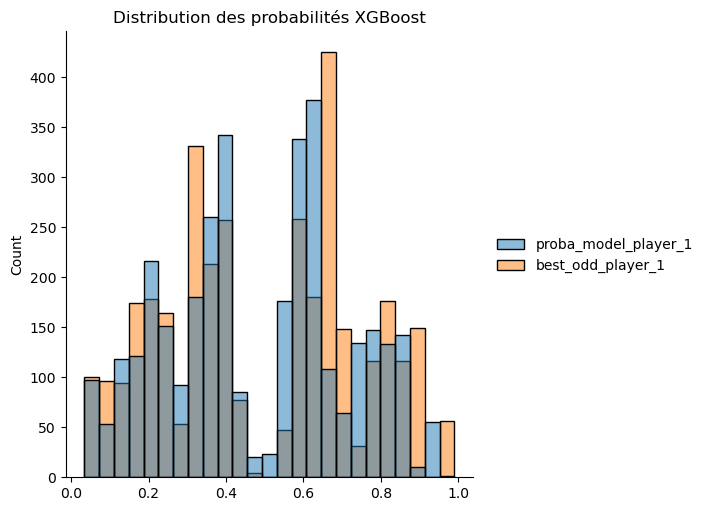

In [13]:
#Vue des statistiques
print(value_bets['money_won'].describe())
#Graphe montrant la répartition des probas du modèle vs les bookmakers :
sns.displot((value_bets['proba_model_player_1'],1/value_bets['best_odd_player_1']),kind = 'hist',bins = 25, label = ['Probas RF','Probas Bookmakers'])
plt.title('Distribution des probabilités XGBoost');